# APHY 140 Exer 6 (Part 2)

Implemented by: Kernel Godwin Enriquez, Francis Lance Leal, and Timothy Allen Teves

## Lesson 3. Calculate and Plot Difference Normalized Burn Ration (dNBR) using the Landsat 8 Remote Sensing Data in Python

 ### Loading all the required Python libraries

In [2]:
import os
from glob import glob

import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
from matplotlib.colors import ListedColormap
from matplotlib import colors
import seaborn as sns
import numpy as np
import numpy.ma as ma
from shapely.geometry import mapping, box
from rasterio.plot import plotting_extent
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

# Prettier plotting with seaborn
sns.set_style('white')
sns.set(font_scale=1.5)

# Set working directory
os.chdir(os.path.join(et.io.HOME, 
                      'earth-analytics', 
                      'data'))

### Preparation of Landsat pre-fire and post-fire data for the calculation of NBR

In [3]:
def combine_tifs(tif_list):
    """A function that combines a list of tifs in the same CRS
    and of the same extent into an xarray object

    Parameters
    ----------
    tif_list : list
        A list of paths to the tif files that you wish to combine.

    Returns
    -------
    An xarray object with all of the tif files in the listmerged into 
    a single object.

    """

    out_xr = []
    for i, tif_path in enumerate(tif_list):
        out_xr.append(rxr.open_rasterio(tif_path, masked=True).squeeze())
        out_xr[i]["band"] = i+1

    return xr.concat(out_xr, dim="band")

### Post-Fire Data:

In [4]:
# Import and stack post fire Landsat data - notice you are only stacking bands 5-7
all_landsat_bands_path = glob(os.path.join("cold-springs-fire",
                                           "landsat_collect",
                                           "LC080340322016072301T1-SC20180214145802",
                                           "crop",
                                           "*band[5-7]*.tif"))

all_landsat_bands_path.sort()

landsat_post_fire = combine_tifs(all_landsat_bands_path)

extent_landsat = plotting_extent(
    landsat_post_fire[0].values, landsat_post_fire.rio.transform())

landsat_post_fire

<xarray.DataArray (band: 3, y: 177, x: 246)> Size: 523kB
array([[[2445., 2271., 2417., ..., 1734., 1904., 2101.],
        [2662., 2465., 2532., ..., 1736., 1824., 2165.],
        [2880., 2872., 2750., ..., 1897., 2116., 2300.],
        ...,
        [1900., 1917., 2076., ..., 1722., 1891., 1890.],
        [1779., 1893., 1983., ..., 1645., 1847., 2090.],
        [1553., 1440., 1587., ..., 1562., 1689., 1964.]],

       [[2864., 2974., 3108., ...,  983., 1195., 1271.],
        [2527., 2827., 3008., ..., 1132., 1293., 1546.],
        [2141., 2427., 2433., ..., 1324., 1652., 1922.],
        ...,
        [1662., 1757., 1922., ..., 1463., 1472., 1519.],
        [1786., 1532., 1554., ..., 1374., 1423., 1450.],
        [1071.,  943.,  975., ..., 1524., 1461., 1518.]],

       [[1920., 1979., 2098., ...,  537.,  660.,  687.],
        [1505., 1863., 1975., ...,  651.,  747.,  924.],
        [1240., 1407., 1391., ...,  769., 1018., 1189.],
        ...,
        [1216., 1190., 1398., ...,  877.,  890.,  928.],
        [1517., 1184., 1078., ...,  846.,  810.,  820.],
        [ 660.,  593.,  623., ...,  984.,  909.,  880.]]], dtype=float32)
Coordinates:
  * band         (band) int32 12B 1 2 3
  * x            (x) float64 2kB 4.557e+05 4.557e+05 ... 4.63e+05 4.63e+05
  * y            (y) float64 1kB 4.428e+06 4.428e+06 ... 4.423e+06 4.423e+06
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  5571
    STATISTICS_MEAN:     1958.570001378
    STATISTICS_MINIMUM:  -2
    STATISTICS_STDDEV:   557.005903918
    scale_factor:        1.0
    add_offset:          0.0

In [5]:
# Open fire boundary layer and reproject it to match the Landsat data
fire_boundary_path = os.path.join("cold-springs-fire",
                                  "vector_layers",
                                  "fire-boundary-geomac",
                                  "co_cold_springs_20160711_2200_dd83.shp")

fire_boundary = gpd.read_file(fire_boundary_path)

# If the CRS are not the same, be sure to reproject
fire_bound_utmz13 = fire_boundary.to_crs(landsat_post_fire.rio.crs)

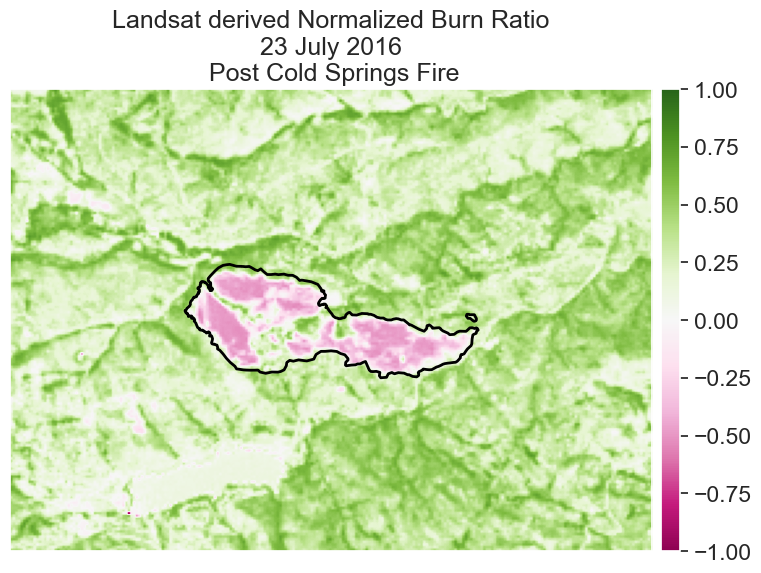

Figure 1. Normalized burn ratio (NBR) calculated for the post-Cold Springs fire image for July 23, 2016 from Landsat.


In [6]:
# Calculate post-fire NBR & plot
landsat_postfire_nbr = (
    landsat_post_fire[0]-landsat_post_fire[2]) / (landsat_post_fire[0]+landsat_post_fire[2])

fig, ax = plt.subplots(figsize=(12, 6))

ep.plot_bands(landsat_postfire_nbr,
              cmap='PiYG',
              vmin=-1,
              vmax=1,
              ax=ax,
              extent=extent_landsat,
              title="Landsat derived Normalized Burn Ratio\n 23 July 2016 \n Post Cold Springs Fire")

fire_bound_utmz13.plot(ax=ax,
                       color='None',
                       edgecolor='black',
                       linewidth=2)
plt.show()
print ("Figure 1. Normalized burn ratio (NBR) calculated for the post-Cold Springs fire image for July 23, 2016 from Landsat.")

The Landsat-derived Normalized Burn Ratio (NBR) plot captures the immediate aftermath of the Cold Springs Fire in Colorado and provides a spatial depiction of burn severity across the landscape. The use of NBR allows for the effective detection of burned areas by comparing near-infrared (NIR) and shortwave infrared (SWIR) reflectance, leveraging the fact that healthy vegetation reflects strongly in the NIR and poorly in the SWIR, while burned areas show the opposite pattern. In the figure, magenta colors dominate the central portion enclosed by a boundary (black line), clearly marking the fire-affected zone. These negative NBR values indicate strong SWIR reflectance—typical of charred earth and vegetation. In contrast, the surrounding areas outside the burn perimeter exhibit various shades of green, with NBR values approaching +1, which are indicative of unburned and healthy vegetation. The sharp boundary also suggests a relatively well-defined fire perimeter, which may help guide field validation and future recovery monitoring. 

It is also worth noting that while the NBR is highly effective in mapping fire scars, it can be sensitive to water bodies, which may also appear as low NBR values. However, the coherent shape and location of the affected region suggest a true fire scar rather than water-related false positives.


### Pre-Fire Data:

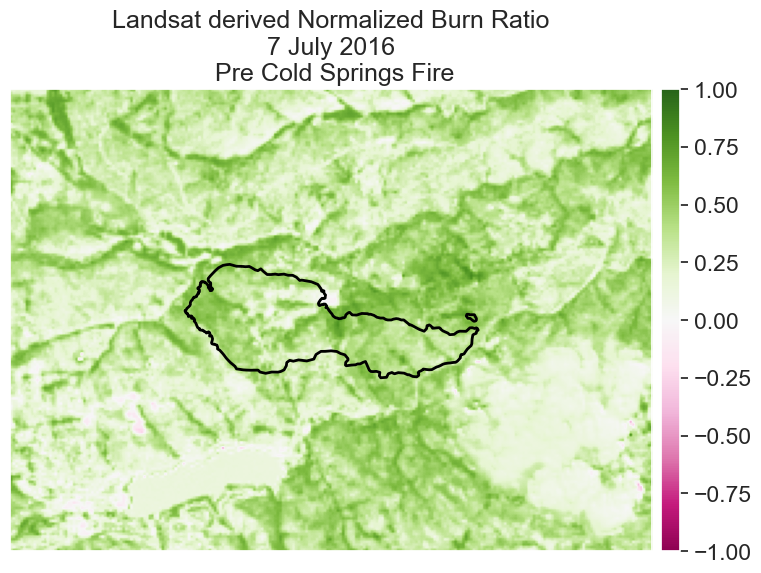

Figure 2. Normalized burn ratio (NBR) calculated for the pre-Cold Springs fire image from Landsat.


In [7]:
# Import and stack pre-fire Landsat data
pre_fire_band_paths=glob(os.path.join("cold-springs-fire",
                                        "landsat_collect",
                                        "LC080340322016070701T1-SC20180214145604",
                                        "crop",
                                        "*band[5-7]*.tif"))
pre_fire_band_paths.sort()

landsat_pre_fire = combine_tifs(pre_fire_band_paths)

# Calculate pre-fire NBR
landsat_prefire_nbr = (landsat_pre_fire[0] - landsat_pre_fire[2]) / (landsat_pre_fire[0] + landsat_pre_fire[2])

# Plot the result
fig, ax = plt.subplots(figsize=(12, 6))
ep.plot_bands(landsat_prefire_nbr,
              cmap='PiYG',
              vmin=-1,
              vmax=1,
              ax=ax,
              extent=extent_landsat,
              title="Landsat derived Normalized Burn Ratio\n 7 July 2016 \n Pre Cold Springs Fire")

fire_bound_utmz13.plot(ax=ax,
                       color='None',
                       edgecolor='black',
                       linewidth=2)
plt.show()
print ("Figure 2. Normalized burn ratio (NBR) calculated for the pre-Cold Springs fire image from Landsat.")

The calculated Normalized Burn Ratio (NBR) is depicted in Figure 2. It shows the same outline of the area that was affected by the fire. Comparing it with Figure 1 which was the aftermath of the fire, the NBR values were above 0 indicating healthy vegetation. With this, the Pre-Cold Springs Fire shall be the foundation of the effect of the burning resulting in the Post-Cold Springs Fire in which they are related to dNBR as pre fire data minus the post fire data. 

In [8]:
# Are the before and after data the same shape?
landsat_pre_fire.shape == landsat_post_fire.shape

True

### Calculation for the Difference Normalized Burn Ratio (dNBR)

In [9]:
# Calculate dnbr
dnbr_landsat = landsat_prefire_nbr - landsat_postfire_nbr
dnbr_landsat

<xarray.DataArray (y: 177, x: 246)> Size: 174kB
array([[ 0.06053689,  0.09801085,  0.13565655, ..., -0.02277768,
        -0.03019354,  0.00112736],
       [ 0.03737938,  0.09320462,  0.11856693, ..., -0.00827491,
        -0.00438508,  0.00114849],
       [ 0.00139973,  0.06205684,  0.08142802, ..., -0.00807688,
         0.00647721,  0.00447503],
       ...,
       [-0.07159956, -0.00260067,  0.02915099, ..., -0.01685438,
         0.02431214,  0.03168178],
       [ 0.08337121, -0.14558633, -0.07208158, ..., -0.03929183,
        -0.02250457, -0.01183644],
       [-0.111083  ,  0.02821738, -0.00633484, ...,  0.00962946,
        -0.02222264, -0.03099948]], dtype=float32)
Coordinates:
  * x            (x) float64 2kB 4.557e+05 4.557e+05 ... 4.63e+05 4.63e+05
  * y            (y) float64 1kB 4.428e+06 4.428e+06 ... 4.423e+06 4.423e+06
    spatial_ref  int32 4B 0

### Classification of different dNBR range of values

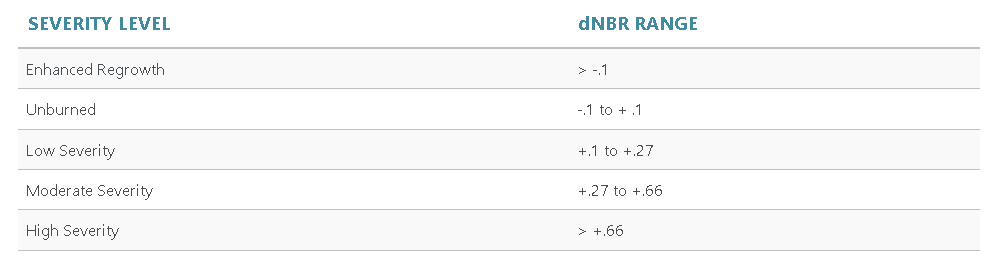

In [10]:
# Define dNBR classification bins
dnbr_class_bins = [-np.inf, -.1, .1, .27, .66, np.inf]

#dnbr_landsat_class = np.digitize(dnbr_landsat, dnbr_class_bins)

dnbr_landsat_class = xr.apply_ufunc(np.digitize,
                                    dnbr_landsat,
                                    dnbr_class_bins)
dnbr_landsat_class

<xarray.DataArray (y: 177, x: 246)> Size: 348kB
array([[2, 2, 3, ..., 2, 2, 2],
       [2, 2, 3, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 1, 2, ..., 2, 2, 2],
       [1, 2, 2, ..., 2, 2, 2]], dtype=int64)
Coordinates:
  * x            (x) float64 2kB 4.557e+05 4.557e+05 ... 4.63e+05 4.63e+05
  * y            (y) float64 1kB 4.428e+06 4.428e+06 ... 4.423e+06 4.423e+06
    spatial_ref  int32 4B 0

In [11]:
dnbr_cat_names = ["Enhanced Regrowth",
                  "Unburned",
                  "Low Severity",
                  "Moderate Severity",
                  "High Severity"]

nbr_colors = ["g",
              "yellowgreen",
              "peachpuff",
              "coral",
              "maroon"]
nbr_cmap = ListedColormap(nbr_colors)

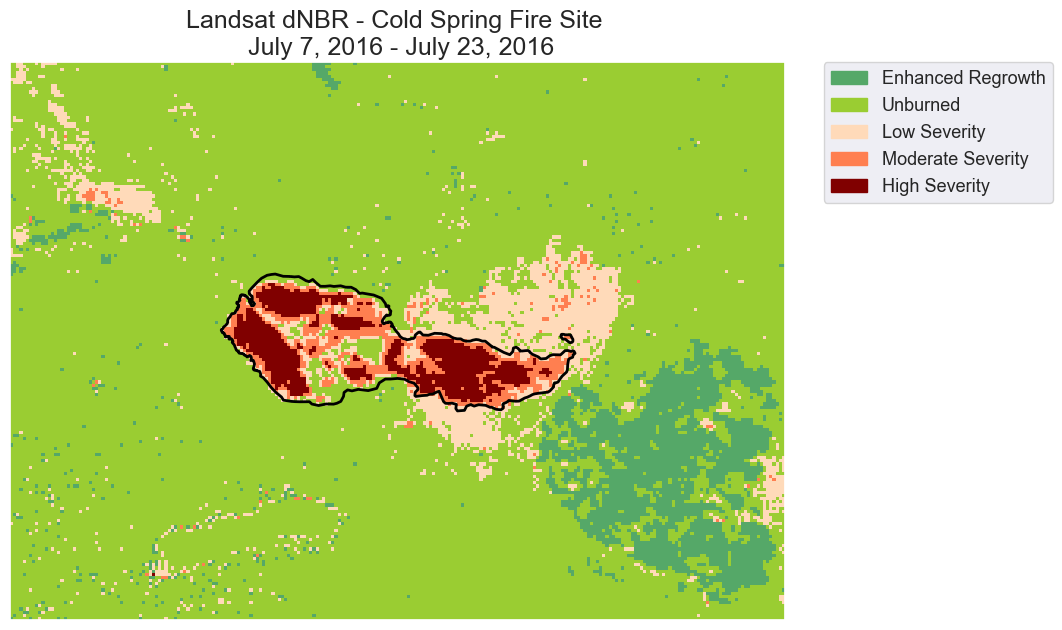

Figure 4. Classified difference normalized burn ratio (dNBR) calculated for the Cold Springs fire images from Landsat, with legend created using matplotlib.


In [12]:
# Plot the data with a custom legend
dnbr_landsat_class_plot = ma.masked_array(
    dnbr_landsat_class.values, dnbr_landsat_class.isnull())

fig, ax = plt.subplots(figsize=(10, 8))

fire_bound_utmz13.plot(ax=ax,
                       color='None',
                       edgecolor='black',
                       linewidth=2)

classes = np.unique(dnbr_landsat_class_plot)
classes = classes.tolist()[:5]

ep.plot_bands(dnbr_landsat_class_plot,
              cmap=nbr_cmap,
              vmin=1,
              vmax=5,
              title="Landsat dNBR - Cold Spring Fire Site \n July 7, 2016 - July 23, 2016",
              cbar=False,
              scale=False,
              extent=extent_landsat,
              ax=ax)

ep.draw_legend(im_ax=ax.get_images()[0],
               classes=classes,
               titles=dnbr_cat_names)

plt.show()
print ("Figure 4. Classified difference normalized burn ratio (dNBR) calculated for the Cold Springs fire images from Landsat, with legend created using matplotlib.")

The result of the difference between the pre fire and post fire was calculated. The result of dNBR was classified by the degree of severity based on the range values of dNBR of the raster output. The function used for this was ‘np.digitize()’ in order to align the values with the classification. It was easier to visualize the data as it efficiently assigns pixels to a class which was plotted later on.

### Calculation of the Total Area of Burned Area

In [13]:
# To calculate area, multiply:
# number of pixels in each bin by image resolution
# Result will be in total square meters

landsat_pixel = landsat_pre_fire.rio.resolution(
)[0] * landsat_pre_fire.rio.resolution()[0]

burned_landsat = (dnbr_landsat_class == 5).sum()
burned_landsat = np.multiply(burned_landsat, landsat_pixel).values

print("Landsat Severe Burn Area:", burned_landsat)

Landsat Severe Burn Area: 950400.0


## Extra Lessons:

### Creating a Color Bar Legend

In [14]:
# Grab raster unique values (classes)
values = np.unique(dnbr_landsat_class).tolist()

# Add another index value because for n categories
# you need n+1 values to create bins
values = [0] + values

# Make a color map of fixed colors
nbr_colors = ["g", "yellowgreen", "peachpuff", "coral", "maroon"]
nbr_cmap = ListedColormap(nbr_colors)

# But the goal is the identify the MIDDLE point
# of each bin to create a centered tick
bounds = [((a + b) / 2) for a, b in zip(values[:-1], values[1::1])] + [5.5]

# Define normalization
norm = colors.BoundaryNorm(bounds, nbr_cmap.N)

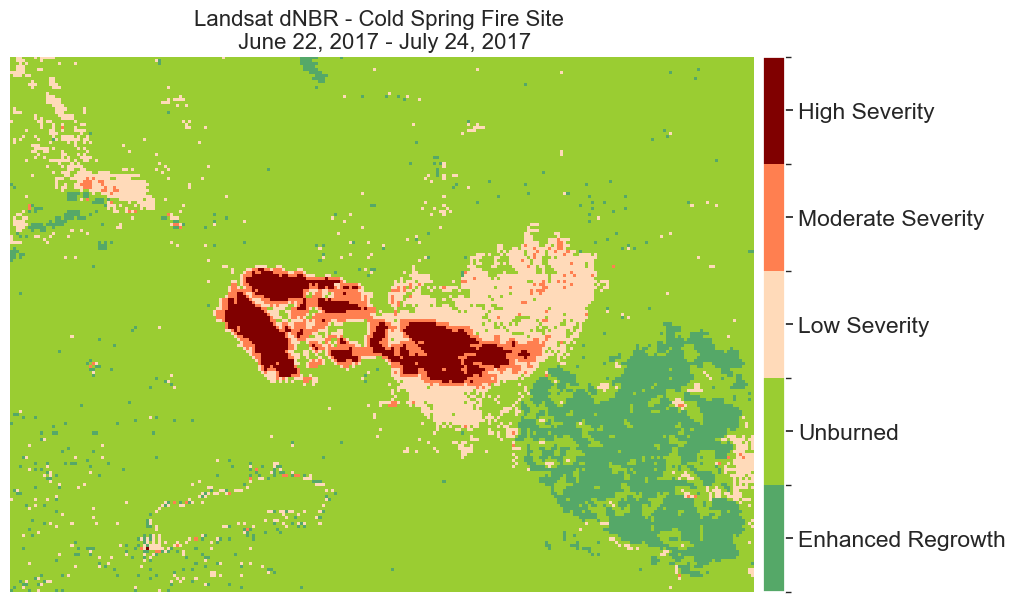

Figure 4. Landsat dNBR - Cold Spring Fire Site


In [15]:
# Plot the data
fig, ax = plt.subplots(figsize=(10, 8))

ep.plot_bands(dnbr_landsat_class,
              ax=ax,
              cmap=nbr_cmap,
              norm=norm,
              cbar=False)

cbar = ep.colorbar(ax.get_images()[0])

cbar.set_ticks(np.unique(dnbr_landsat_class))
cbar.set_ticklabels(dnbr_cat_names)
ax.set_title("Landsat dNBR - Cold Spring Fire Site \n June 22, 2017 - July 24, 2017",
             fontsize=16)

# Turn off ticks
ax.set_axis_off()
plt.show()
print ("Figure 4. Landsat dNBR - Cold Spring Fire Site")

In order to visualize the dNBR data, the output was classified into discrete colormaps under different degrees of severity levels. This shows that this method was able to categorize and manipulate the data array in order to plot the classified burn severity map and customize both the visual appearance that would help in producing correct interpretation.


### Exporting dNBR Raster to Geotiff

In [16]:
# Create a path to export the data too
dnbr_path = os.path.join("cold-springs-fire", "outputs", "dnbr_landsat.tif")

# Export the data as int8
dnbr_landsat_class.rio.to_raster(dnbr_path, dtype="int8")

# Open and view the exported data
# Note the default datatype to open a raster as is float32!
rxr.open_rasterio(dnbr_path).squeeze()

<xarray.DataArray (y: 177, x: 246)> Size: 44kB
[43542 values with dtype=int8]
Coordinates:
    band         int32 4B 1
  * x            (x) float64 2kB 4.557e+05 4.557e+05 ... 4.63e+05 4.63e+05
  * y            (y) float64 1kB 4.428e+06 4.428e+06 ... 4.423e+06 4.423e+06
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

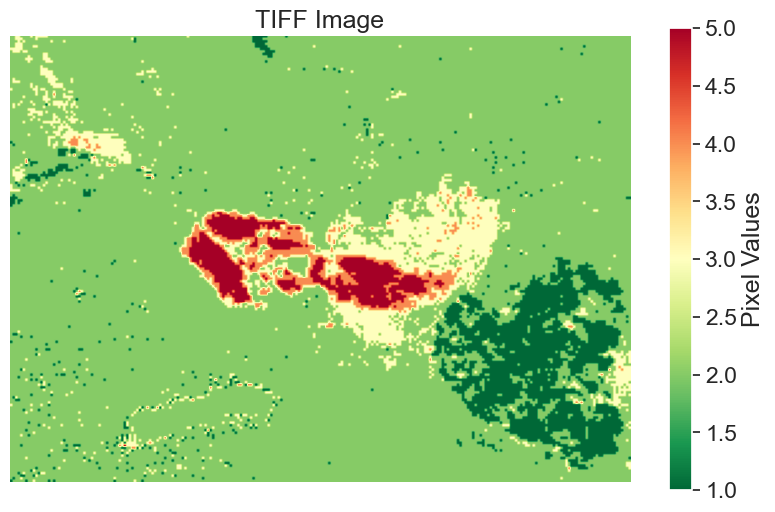

In [17]:
# Viewing the output TIFF file
tif_path = "cold-springs-fire/outputs/dnbr_landsat.tif"
tif_data = rxr.open_rasterio(tif_path, masked=True).squeeze()
plt.figure(figsize=(10, 6))
plt.imshow(tif_data, cmap="RdYlGn_r")
plt.title("TIFF Image")
plt.axis("off")
plt.colorbar(label="Pixel Values")
plt.show()